In [65]:
import pandas as pd
import random
import numpy as np
import spacy
from tqdm import tqdm
from pprint import pprint
import re
import os
import time
import pickle
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import nltk.data
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import line_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.chunk import tree2conlltags
from sklearn.model_selection import train_test_split
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import PorterStemmer
from nltk.stem.porter import *
from gensim import corpora, models
from wordcloud import WordCloud, STOPWORDS
import nltk, math, codecs
from gensim.models import Doc2Vec
from nltk.cluster.kmeans import KMeansClusterer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
pd.set_option('display.max_colwidth', 200)
from nltk.collocations import *
import warnings
warnings.filterwarnings("ignore")

In [ ]:
nltk.download('all')

In [111]:
n=1000000
s=950000
random.seed(3358439386)
skip = sorted(random.sample(range(n),n-s))
data = pd.read_csv("/Users/sbalas203/Downloads/Chomsky-NLP/ivr_utterances_april.csv", skiprows=skip, header=0)

In [112]:
data.head(5)

,REPORTED_UTTERANCE_TEXT,IVR_END_STATUS_NM,CUSTOMER_ACCOUNT_ID,IVR_CUSTOMER_MARKET_NM,CALL_DATE,REPORTED_NAVIGATION_MODULE_NM,REPORTED_NAVIGATION_MODULE_FUNCTION_NM,LAST_NON_TRANSFER_MODULE_NM,LAST_NON_TRANSFER_MODULE_FUNCTION_NM
0,billing,info_delivery,541620657.0,Freedom,2020-04-30,BILLING,BillingVideoX1SMS,BILLING,BillingVideoX1SMS
1,have no,agent,21890378.0,Greater Chicago,2020-04-30,TECHNICAL,BoxHit_Legacy,TECHNICAL,RefreshFollowUp
2,i need to speak to someone about my bill,self_service,31121500.0,GBR,2020-04-30,GLOBAL,IVR2XA,CALLERINTENT,MainMenuNL
3,mobile service,agent,546837978.0,Greater Chicago,2020-04-30,GLOBAL,BroadcastMsg,CALLERINTENT,MainMenuNL
4,activate my cable box,agent,543259099.0,Freedom,2020-04-30,GLOBAL,BroadcastMsg,ACTIVATIONS,Device Checks


In [113]:
data.REPORTED_NAVIGATION_MODULE_FUNCTION_NM.value_counts().head(20)

BroadcastMsg         296337
SMSOrCall             87231
PayConfirmation       53096
PaymentConfSMS        49584
ModemResetVerify      46063
BillingAlignment      27091
ModemResetOffer       25764
Agent                 25703
BillingVideoX1SMS     24348
UpdatedBalance        22102
BillingMenus          19682
System Restart        19150
RefreshFollowUp       18686
Delinquent_1          16362
Survey Offer          13840
BoxHit_Legacy         11555
Balance Due           11376
ModemResetOffline     10718
Closed Messages       10643
Device Checks          8906
Name: REPORTED_NAVIGATION_MODULE_FUNCTION_NM, dtype: int64

In [114]:
data['length_of_utterance'] = data['REPORTED_UTTERANCE_TEXT'].str.split().apply(len)
data.head(5)

,REPORTED_UTTERANCE_TEXT,IVR_END_STATUS_NM,CUSTOMER_ACCOUNT_ID,IVR_CUSTOMER_MARKET_NM,CALL_DATE,REPORTED_NAVIGATION_MODULE_NM,REPORTED_NAVIGATION_MODULE_FUNCTION_NM,LAST_NON_TRANSFER_MODULE_NM,LAST_NON_TRANSFER_MODULE_FUNCTION_NM,length_of_utterance
0,billing,info_delivery,541620657.0,Freedom,2020-04-30,BILLING,BillingVideoX1SMS,BILLING,BillingVideoX1SMS,1
1,have no,agent,21890378.0,Greater Chicago,2020-04-30,TECHNICAL,BoxHit_Legacy,TECHNICAL,RefreshFollowUp,2
2,i need to speak to someone about my bill,self_service,31121500.0,GBR,2020-04-30,GLOBAL,IVR2XA,CALLERINTENT,MainMenuNL,9
3,mobile service,agent,546837978.0,Greater Chicago,2020-04-30,GLOBAL,BroadcastMsg,CALLERINTENT,MainMenuNL,2
4,activate my cable box,agent,543259099.0,Freedom,2020-04-30,GLOBAL,BroadcastMsg,ACTIVATIONS,Device Checks,4


In [115]:
data = data[data.REPORTED_NAVIGATION_MODULE_FUNCTION_NM == "Survey Offer"]
data.head(5)

,REPORTED_UTTERANCE_TEXT,IVR_END_STATUS_NM,CUSTOMER_ACCOUNT_ID,IVR_CUSTOMER_MARKET_NM,CALL_DATE,REPORTED_NAVIGATION_MODULE_NM,REPORTED_NAVIGATION_MODULE_FUNCTION_NM,LAST_NON_TRANSFER_MODULE_NM,LAST_NON_TRANSFER_MODULE_FUNCTION_NM,length_of_utterance
37,changing service resuming recorder with service,info_delivery,15730882.0,GBR,2020-04-30,TRANSFER,Survey Offer,CALLERINTENT,NLDisambig_Reprompt,6
231,service disconnection,agent,275819682.0,Beltway,2020-04-30,TRANSFER,Survey Offer,CALLERINTENT,NLDisambig_OtherMenus,2
340,billing support,info_delivery,533105844.0,Portland,2020-04-30,TRANSFER,Survey Offer,BILLING,BillingAgent,2
552,billing issues customer service,agent,45357238.0,Beltway,2020-04-30,TRANSFER,Survey Offer,CALLERINTENT,MainMenuNL,4
622,billing inquiry,info_delivery,514704824.0,Nashville,2020-04-30,TRANSFER,Survey Offer,BILLING,BillingAgent,2


In [116]:
#data = data[data.length_of_utterance > 5]
#data.head(5)

In [14]:
def lemmatize_stemming(text):
    return PorterStemmer().stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [15]:
from gensim.parsing.porter import PorterStemmer
def lemmatize_stemming(text):
    return PorterStemmer().stem(text)

In [16]:
processed_docs = data['REPORTED_UTTERANCE_TEXT'].map(preprocess)
processed_docs[:20]

75                                                             []
96                                                         [work]
141                                                  [cabl, work]
195                                              [video, problem]
221                                                        [come]
239                                               [lost, station]
264                                       [signal, error, messag]
278     [said, pictur, pictur, demand, on_demand, singl, channel]
309                                            [main, cabl, work]
384                                                 [remot, work]
422                                                      [servic]
629                                                      [pictur]
741                                                  [cabl, work]
796                                   [technic, support, televis]
894              [televis, work, keep, tell, check, signal, cabl]
953       

In [17]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 work
1 cabl
2 problem
3 video
4 come
5 lost
6 station
7 error
8 messag
9 signal
10 channel


In [18]:
dictionary.filter_extremes(no_below=5, no_above=0.4, keep_n=10000)

In [19]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[2]

[(0, 1), (1, 1)]

In [20]:
bow_doc_1 = bow_corpus[100]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                               dictionary[bow_doc_1[i][0]], 
bow_doc_1[i][1]))

Word 1 ("cabl") appears 1 time.


In [21]:
#LDA using bag of words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(5,4):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.263*"technic" + 0.248*"support" + 0.095*"channel" + 0.066*"signal"
Topic: 1 
Words: 0.134*"connect" + 0.088*"televis" + 0.065*"issu" + 0.052*"get"
Topic: 2 
Words: 0.519*"servic" + 0.091*"lost" + 0.055*"restor" + 0.022*"signal"
Topic: 3 
Words: 0.258*"work" + 0.253*"cabl" + 0.044*"yeah" + 0.038*"t_v"
Topic: 4 
Words: 0.127*"pictur" + 0.126*"problem" + 0.065*"work" + 0.064*"cabl"


In [ ]:
#LDA using bag of words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=20, id2word=dictionary, passes=2, workers=2)
for idx, topic in lda_model.print_topics(20,4):
    print('Topic: {} \nWords: {}'.format(idx, topic))

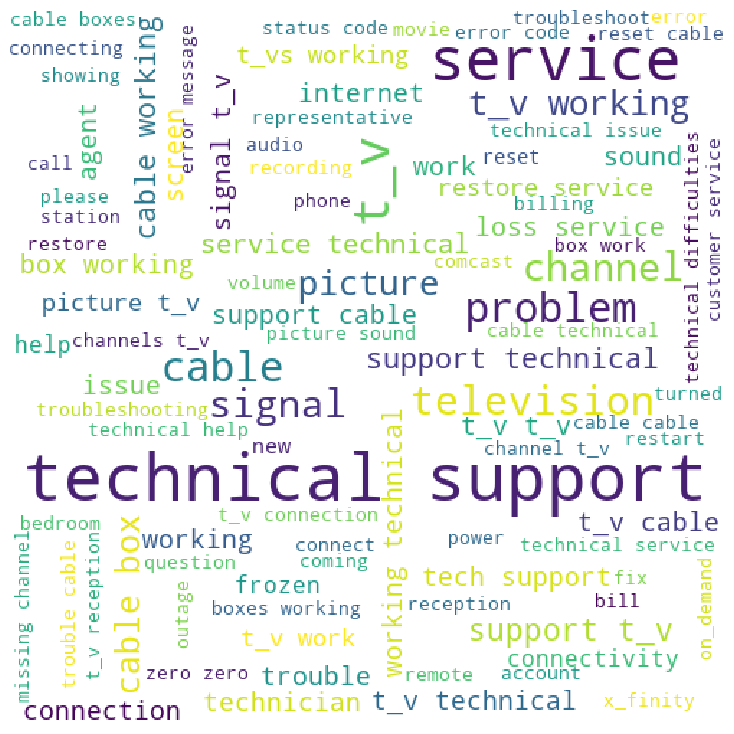

In [22]:
comment_words = ' '
stopwords = set(STOPWORDS) 
#Specify a list of stop words to remove
more_stops=['I','say','wanna','hello','na','gon','get','uh','right','guy','still','come','say','someth','mean','um','oh','yes','bye','great','yeah','no','sorry','ok','okay','thank','like','alright','know','a',
 'about','above','after','again','against','all','also','am','an','and','any','are',"aren't",'as', 'at','be','because','been','before','being','below','between','both','but','by','can',"can't",
            'cannot','com','could',"couldn't",'did', 'ye','my','pai','finity',
            "didn't",'do','does', "doesn't",'doing',"don't",'down','during','each','else','ever', 'few','for','from','further','get','had',"hadn't",'has',"hasn't",'have',"haven't",
'having','he',"he'd","he'll","he's",'her','here',"here's",'hers','herself','him','himself','his','how',"how's",'however','http','i',"i'd","i'll","i'm","i've",'if','in','into','is',"isn't",
 'it',"it's",'its','itself','just','k',"let's",'like','me','more','most',"mustn't",'my','myself','no','nor','not','of','off','on','once','only','or','other','otherwise','ought','our','ours','ourselves',
            'out','over','own','r','same',
            'shall',"shan't",'she',"she'd","she'll","she's",
 'should',"shouldn't",'since','so','some','such','than','that',"that's",'the','their','theirs','them','themselves','then','there',"there's",'these','they',"they'd","they'll","they're","they've",'this','those',
            'through','to',
 'too','under','until','up','very','was','said',"wasn't",'we','got', "we'd","we'll","we're","we've",'were',"weren't",'what',"what's",'when',"when's",'where',"where's",'which','while','who',"who's",'whom',
'why',"why's",'with',"won't",'would',"wouldn't",'www','you',"you'd","you'll","you're","you've",'your','yours','yourself','yourselves','going','see','nothing','well','one','want', 'us', 'for', 'am', 'say', 'and', 'been',
              'someone', 'that', 'so', 'for', 'why', 'am', 'or', 'else', 'main', 'if', 'need', 'do',
              'know', 'want', 'them', 'back', 'will', 'all', 'keep', 'a', 's', 'too', 'at', 'way', 'with',
              'when', 'we', 'with', 'since', 'at', 'does', 're', 'when', 'give', 'talk', 'got',
              'them', 'someone', 'told', 'back', 'way', 'is', 'too', 'its', 'much', 'going', 'keeps',
              'goes', 'every', 'went', 'and', 'been', 'with', 'some', 've', 'we', 'a', 'had', 'and'
    , 'went', 'on', 'all', 'see', 'make', 'say', 'us', 's', 'came','lot','able','takes','think','it','i','try','bit','for',
             'thats','much','getting','really','now','t','turn','for','me',' t','it','getting','now',' me',' t','  t','much',
             'days','now','thought','thats','fact','looking','choose','thing','enough','overall','fine','far',
             'everytime','whenever','always','long','alot','needed','recently','wish','done','usually',
              'sometimes','pretty','month','year','im','change','hold','trying','l','1','ou','d','putting','put',
              'didnt','comes','come','needs','need','seems','seem','tried','try','mostly','sure','certain',
              'cant','can','wanted','want','changes','change','last','first','several','couple','took','take','times',
              'prices','paying','though','thought','feel','live','another','depends','choices',
              'day','minute','minutes','everything','options','better','compared','calling','quickly','week',
              'speak','hours','person','day','faster','less','ten','show','night','theres','part','yet','number',
              'ive','weeks','asked','ask','stuff','little','almost','beleive','believe','dont','somebody',
              'using', 'never','happens','three','five','two','ago','constantly','basically','around','used',
              'others','probably','quite','except','everyone','lost','extremely','higher','wait','tell','kind',
              'end','something','others','job','months','wrong','check','lately','even','provide',
              'job','changing','everybody','second','gets','many','find','supposed','without','taken','gone','cuts',
              'called','use','many','guys','things','whole','anymore','big','understand','rip','realized','robert','kyle','curtis','letting',
              'becoming','depend','elsewhere','effect','letting','tells','sixth','st','stating','st','somehow','frankly','body','originally','op','must'
              ,'automatically','steve','fi','include','anyways'] 

stop_words = set(nltk.corpus.stopwords.words('english')+more_stops)


# iterate through the csv file 
for val in data.REPORTED_UTTERANCE_TEXT: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show() 

In [23]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# Convert to list
data = data.REPORTED_UTTERANCE_TEXT.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:2])

['yes', 't_v does not work']


<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-24-135bad5ffbf8>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-24-135bad5ffbf8>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['yes']]


In [26]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['t_v', 'does', 'not', 'work']


In [27]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[[], ['work']]


In [152]:
type(data_words_bigrams)

list

In [153]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[]]


In [154]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[]]

In [155]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [157]:
#model evaluation
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.523758818488958

Coherence Score:  0.5491436461719041


In [ ]:
lda_model.top_topics(bow_corpus)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [87]:
from textblob import TextBlob

In [88]:
data['sentiment'] = data['REPORTED_UTTERANCE_TEXT'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [89]:
data['sentiment'].value_counts()

 0.000000    24488
 0.200000      870
-0.125000      805
-0.187500      326
 0.136364       66
             ...  
 0.050000        1
 0.077778        1
 0.112121        1
-0.800000        1
 0.075000        1
Name: sentiment, Length: 107, dtype: int64

In [90]:
#positive utternaces
data[["REPORTED_UTTERANCE_TEXT","sentiment"]].loc[(data['sentiment'] > 0)].sample(10)

,REPORTED_UTTERANCE_TEXT,sentiment
167674,yes ma'am grass speak to one supervisor name is much do you on,0.200000
58837,wanna_know how much my bill is,0.200000
572197,how much is my bill,0.200000
738424,um need_to_know how much what date,0.200000
148314,new billing,0.136364
289102,how much is my bill,0.200000
338047,how much is my bill,0.200000
340424,how much my bill when is due,0.037500
651512,how much do i owe on one next bill,0.100000
134383,old bill,0.100000


In [91]:
#negative utterances
data[["REPORTED_UTTERANCE_TEXT","sentiment"]].loc[(data['sentiment'] < 0)].sample(10)

,REPORTED_UTTERANCE_TEXT,sentiment
193788,bill balance and payment due date,-0.1250
852198,my past due balance,-0.1875
600834,make a past due balance payment,-0.1875
371935,card balance due,-0.1250
776599,balance due,-0.1250
478283,due date,-0.1250
855587,balance due,-0.1250
381569,with my past due amount,-0.1875
63790,my bill due,-0.1250
102671,due date,-0.1250


AutoEncoder to detect Anomaly utterances

In [92]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text,
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        if f not in stop_words:
            s = f(s)
    return s

In [93]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in data.iterrows():
    c = Counter(row['REPORTED_UTTERANCE_TEXT'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [94]:
data['REPORTED_UTTERANCE_TEXT'] = data['REPORTED_UTTERANCE_TEXT'].map(lambda x: clean_text(x))

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

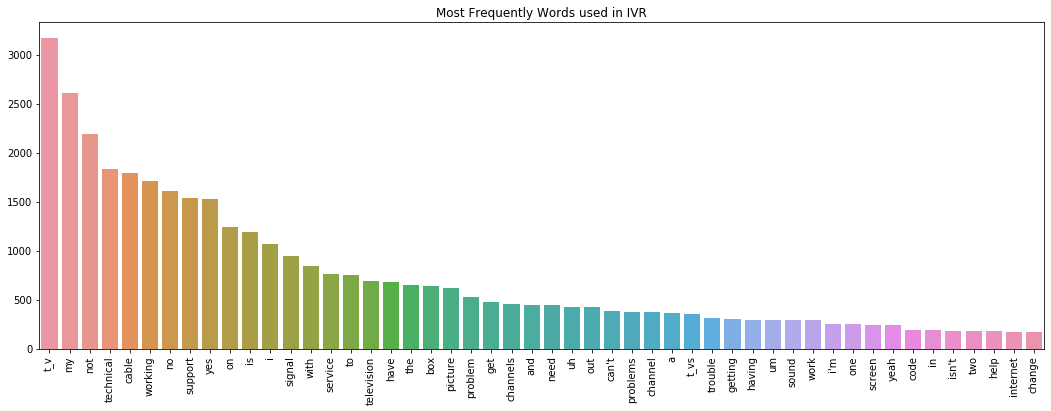

In [96]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequently Words used in IVR')

In [97]:
from itertools import islice

def key_word_counter(tupple):
    return tupple[1]

all_word_counts = sorted(aggregate_counter.items(), key=key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)]  

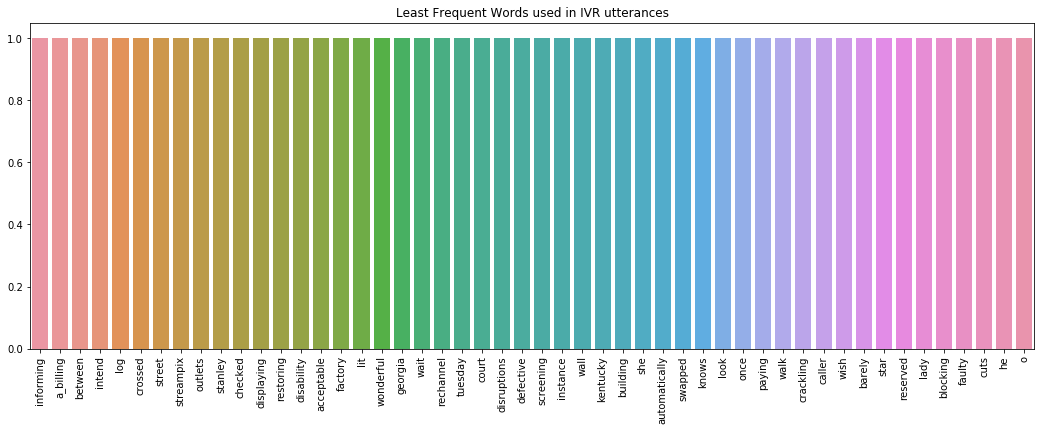

In [98]:
barplot(words=uncommon_words, words_counts=uncommon_word_counts, title='Least Frequent Words used in IVR utterances')

In [117]:
#text documents to word vector
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=15, learning_rate=0.01, epochs=10):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['REPORTED_UTTERANCE_TEXT']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['REPORTED_UTTERANCE_TEXT']).split())
                                     for index, row in df_x.iterrows()]))

In [118]:
doc2vec_tr = Doc2VecTransformer(vector_size=10)
doc2vec_tr.fit(data)
doc2vec_vectors = doc2vec_tr.transform(data)

100%|██████████| 13840/13840 [00:00<00:00, 3177990.11it/s]


In [119]:
print(doc2vec_vectors)

[[-3.33318283e+24  2.72622182e+24  1.58713999e+24 ... -5.01558670e+24
   5.02869196e+24  7.87443010e+23]
 [ 6.78365916e+25 -5.54837848e+25 -3.23013119e+25 ...  1.02076663e+26
  -1.02343458e+26 -1.60259629e+25]
 [ 3.52572656e+23 -2.88370366e+23 -1.67882233e+23 ...  5.30531638e+23
  -5.31917918e+23 -8.32930393e+22]
 ...
 [-6.52891147e+24  5.34001939e+24  3.10883007e+24 ... -9.82433929e+24
   9.85001254e+24  1.54241355e+24]
 [ 3.17423716e-02 -4.60119396e-02  8.65242165e-03 ...  4.33041640e-02
   3.89591642e-02 -4.40265089e-02]
 [ 1.15617836e+24 -9.45642287e+23 -5.50529998e+23 ...  1.73975207e+24
  -1.74429818e+24 -2.73139715e+23]]


In [120]:
doc2vec_vectors1 = doc2vec_vectors
doc2vec_vectors1 = np.nan_to_num(doc2vec_vectors1, nan=0, posinf=2, neginf=1)
print(doc2vec_vectors1)

[[-3.33318283e+24  2.72622182e+24  1.58713999e+24 ... -5.01558670e+24
   5.02869196e+24  7.87443010e+23]
 [ 6.78365916e+25 -5.54837848e+25 -3.23013119e+25 ...  1.02076663e+26
  -1.02343458e+26 -1.60259629e+25]
 [ 3.52572656e+23 -2.88370366e+23 -1.67882233e+23 ...  5.30531638e+23
  -5.31917918e+23 -8.32930393e+22]
 ...
 [-6.52891147e+24  5.34001939e+24  3.10883007e+24 ... -9.82433929e+24
   9.85001254e+24  1.54241355e+24]
 [ 3.17423716e-02 -4.60119396e-02  8.65242165e-03 ...  4.33041640e-02
   3.89591642e-02 -4.40265089e-02]
 [ 1.15617836e+24 -9.45642287e+23 -5.50529998e+23 ...  1.73975207e+24
  -1.74429818e+24 -2.73139715e+23]]


In [121]:
#Training an autoencoder
from sklearn.neural_network import MLPRegressor
auto_encoder = MLPRegressor(hidden_layer_sizes=(12,9,12))
auto_encoder.fit(doc2vec_vectors1, doc2vec_vectors1)
predicted_vectors = auto_encoder.predict(doc2vec_vectors1)

In [122]:
auto_encoder.score(predicted_vectors, doc2vec_vectors1)

nan

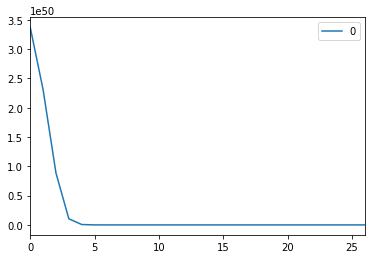

In [123]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [146]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(data)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5000):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        if len(data.iloc[index, 0].split())>4:
            print(' ', data.iloc[index, 0])
        #print('Cosine Similarity Value :', consine_sim_val)
        #print('---------------------------------')

In [147]:
# extract n grams from anomaly utterances
def extract_ngrams(data, num):
    n_grams = TextBlob(data).ngrams(num)
    return [ ' '.join(grams) for grams in n_grams]

In [148]:
def display_top_n_grams(sorted_cosine_similarities, n=5000):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        if len(data.iloc[index, 0].split())>3:
            print(extract_ngrams(data.iloc[index, 0], 5)[0:2])
        #print('Cosine Similarity Value :', consine_sim_val)
        #print('---------------------------------')

In [149]:
print('Top 1000 UTTERANCES')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors1, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Top 1000 UTTERANCES
  need to cancel my account cancel
  want to cancel my account
  need a new cable box
  uh customer service cancel cable
  like to change my service
  cancel account cancel account cancel account
  i need to disconnect my re account
  i need to cancel my service
  need to speak to agent
  need to speak to agent
  talk to customer service bitch
  i need to speak to representative
  need to disconnect my cable service
  i need to lower my bill
  i need to a cancel my service
  like to disconnect my service
  agent to cancel my account
  i need to speak to customer service
  add new channels to my account
  need to change my address
  need to cancel my cable
  i wanna talk to customer service agent
  need to cancel the service
  add cable t_v my account
  questioning my bill want to lower service
  changing service resuming recorder with service
  i need to talk to somebody
  i wanna cancel my cable
  i wanna menu my bill my bill
  like to speak to somebody about uh ch

In [150]:
print('Top 1000 POTENTIAL EMERGING TOPICS')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors1, predicted_vectors=predicted_vectors)
display_top_n_grams(sorted_cosine_similarities=sorted_cosine_similarities)

Top 1000 POTENTIAL EMERGING TOPICS
['need to cancel my account', 'to cancel my account cancel']
['want to cancel my account']
['need a new cable box']
[]
['uh customer service cancel cable']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['like to change my service']
[]
['cancel account cancel account cancel', 'account cancel account cancel account']
[]
[]
[]
[]
[]
[]
['i need to disconnect my', 'need to disconnect my re']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['i need to cancel my', 'need to cancel my service']
['need to speak to agent']
['need to speak to agent']
['talk to customer service bitch']
['wan na talk to agent']
['i need to speak to', 'need to speak to representative']
['need to disconnect my cable', 'to disconnect my cable service']
['i need to lower my', 'need to lower my bill']
[]
['i need to a cancel', 'need to a cancel my']
['like to disconnect my service']
['agent to cancel my account']
[]
['wan na cancel my services']
['i need to speak to', 'need to speak to customer']
[]
[

In [129]:
sorted_cosine_similarities1 = pd.DataFrame(sorted_cosine_similarities)

In [130]:
sorted_cosine_similarities1.head(10)

,0,1
0,8069,-0.815586
1,7175,-0.803495
2,13599,-0.699288
3,11927,-0.661962
4,11103,-0.646109
5,800,-0.623046
6,1152,-0.623046
7,1361,-0.623046
8,1430,-0.623046
9,2123,-0.623046


In [308]:
extract_ngrams("a blue light solid blue come over screen from time time we don't", 5)[1]

'blue light solid blue come'

In [305]:
extract_ngrams("live picture keeps doesn't sound is dropping out the picture keeps stalling", 5)[1]

"picture keeps does n't sound"

In [317]:
extract_ngrams("someone menu has changed i don't get channels that i'm supposed to get", 5)[1]

'menu has changed i do'